# Introduction

This notebook contains the different processes and observations made to carry out the definition and creation of the models using the algorithms and parameter fitting requested in [Technical Requirements](../TechnicalRequirements.pdf).

The sections [Models Definition](#3-models-definition), [Models Selection](#5-models-selection) and [Model Evaluation](#6-model-evaluation) contain the fundamental part of determining the best model for classification based on the insights acquired in [Exploratory Data Analysis](../ExploratoryDataAnalysis/ExploratoryDataAnalysis.ipynb) as well as the justification of the choice of the best model along with the hyper parameters chosen in each model. The model based on Logistic Regression obtained the best performance with respect to the bias-variance trade-off and the one that can be generalized to other instances.

# 0. Importing Libraries and Other Code

In [1]:
# Import libraries

from os import cpu_count
from math import  sqrt , floor

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
# Relevant variables

URL_DATASET = "../Datasets/"

Features = ['age','gender','tot_bilirubin','direct_bilirubin','alkphos','sgpt','sgot','tot_proteins','albumin','ag_ratio']
Target = 'is_patient'

In [3]:
# Auxiliar variables

RANDOM_STATE = 8013
NUM_JOBS = floor(sqrt(cpu_count()))
COLOR_PALETTE = ['#F5AE47','#47AAF5']

## 0.1 Defining Utilities Functions

In [4]:
def SplitFeaturesUsingDatatype(Dataset:pd.DataFrame,Features:list[str]):
    continuous , integer , categorical = [] , [] , []
    
    for feature in Features:
        if (data_type:=Dataset[feature].dtype) == 'float':
            continuous.append(feature)
        elif data_type == 'int':
            integer.append(feature)
        else:
            categorical.append(feature)
    
    return continuous , integer , categorical

In [5]:
def PlotValidationCurve(Model:str):
    global_vars = globals()
    
    train_scores , test_scores = global_vars[f'ValidationCurve_{Model}']
    parameter_name = global_vars[f'Parameter_{Model}']
    parameter_range = global_vars[f'ParameterRange_{Model}']

    fig , axes = plt.subplots(figsize=(8,6))
    axes.plot(parameter_range,train_scores.mean(axis=1),label='Train Scores',c=COLOR_PALETTE[0],ls=':',marker='v')
    axes.plot(parameter_range,test_scores.mean(axis=1),label='Test Scores',c=COLOR_PALETTE[1],ls='--',marker='^')

    axes.set_xlabel(f'Value of {parameter_name[12:]}',size=12)
    axes.set_ylabel('Recall Score',size=12)
    axes.set_ylim(0.5,1+1e-2)
    axes.tick_params(labelsize=10)
    axes.legend(loc=4)

    fig.suptitle(f'Validation Curve of {Model}',size=18)

In [6]:
from sklearn.metrics import recall_score

def EvaluateModels(Models:list[str],Set_X:np.ndarray,Set_y:np.ndarray,NameSets:str):
    print(f'Evaluations on {NameSets} Set\n')

    global_vars = globals()
    for model in Models:
        print(f'Evaluation of {model} ::')
        y_pred = global_vars[f'Model_{model}'].predict(Set_X)
        print(f'Recall :: {recall_score(Set_y,y_pred,pos_label='Yes')}\n')

# 1. Load Dataset

In [7]:
# Loading dataset

LiverDataset = pd.read_csv(URL_DATASET+'IndianLiverPatientDataset_Clean01.csv',index_col=None)

LiverDataset.head(5)

,age,gender,tot_bilirubin,direct_bilirubin,alkphos,sgpt,sgot,tot_proteins,albumin,ag_ratio,is_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,Yes
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,Yes
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,Yes
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,Yes
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,Yes


In [8]:
# Splitting features based on its data types

ContinuousFeatures , IntegerFeatures , CategoricalFeatures = SplitFeaturesUsingDatatype(LiverDataset,Features)

# 2. Preprocessing Pipeline

Referring to the insights acquired in [Exploratory Data Analysis](../ExploratoryDataAnalysis/ExploratoryDataAnalysis.ipynb), some of the numerical attributes are transformed with the ``log10`` function in order to transform their distribution and make the information of these transformed values more relevant to the model. Since the models that are created, based on [Technical Requirements](../TechnicalRequirements.pdf) some of them are based on distance, a standard scaling is applied in order to obtain the values under the same range and measure.

In [9]:
# Import libraries for preprocessing

from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import FunctionTransformer , OrdinalEncoder , StandardScaler
from sklearn.decomposition import PCA

from __AuxiliarFunction import InverseLog10

In [10]:
# Defining preprocessing by feature

PreprocessingFeatures = ColumnTransformer(
    [
        ('NumericalFeaturesTransformation',FunctionTransformer(np.log10,InverseLog10),[*ContinuousFeatures[:2],*IntegerFeatures[1:]]),
        ('CategoricalFeaturesEncode',OrdinalEncoder(),CategoricalFeatures),
    ], remainder='passthrough', n_jobs=NUM_JOBS,force_int_remainder_cols=False
)

In [11]:
# Adding features for PCA

AdditionalFeatures = FeatureUnion(
    [
        ('PCA',PCA(n_components=5,random_state=RANDOM_STATE)),
        ('WithoutChanges','passthrough'),
    ], n_jobs=NUM_JOBS
)

In [12]:
# Defining preprocessing pipeline

PreprocessingPipeline = Pipeline(
    [
        ('PreprocessingFeatures',PreprocessingFeatures),
        ('GeneratingFeatures',AdditionalFeatures),
        ('Scaling',StandardScaler()),
    ]
)

PreprocessingPipeline

Pipeline(steps=[('PreprocessingFeatures',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=4,
                                   remainder='passthrough',
                                   transformers=[('NumericalFeaturesTransformation',
                                                  FunctionTransformer(func=<ufunc 'log10'>,
                                                                      inverse_func=<function InverseLog10 at 0x00000284F9DE8900>),
                                                  ['tot_bilirubin',
                                                   'direct_bilirubin',
                                                   'alkphos', 'sgpt', 'sgot']),
                                                 ('CategoricalFeaturesEncode',
                                                  OrdinalEncoder(),
                                                  ['gender'])])),
                ('GeneratingFeatures',
                 FeatureUnion(n_jobs=4,
                              transformer_list=[('PCA',
                                                 PCA(n_components=5,
                                                     random_state=8013)),
                                                ('WithoutChanges',
                                                 'passthrough')])),
                ('Scaling', StandardScaler())])

# 3. Models Definition

Following the requirements in [Technical Requirements](../TechnicalRequirements.pdf), three models are defined based on Logistic Regression, K Nearest Neighbors and Decision Tree where the best models are selected by varying the regularization factor ``C``, ``n_neighbors`` and ``max_depth`` respectively, leaving the other parameters at their default values because the interest lies in determining how the behavior of the models, prediction, changes when varying the most relevant hyper parameters of the models.

In [13]:
# Import libraries

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
# Defined models

Models = ['LogisticRegression','KNN','DecisionTree']

In [15]:
# Defining Logistic Regression Model

Model_LogisticRegression = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',LogisticRegression(random_state=RANDOM_STATE,n_jobs=NUM_JOBS)),
    ]
)
Parameter_LogisticRegression = 'Classifier__C'
ParameterRange_LogisticRegression = np.linspace(0,2,21)[1:]

Model_LogisticRegression

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function InverseLog10 at 0x00000284F9DE8900>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier',
                 LogisticRegression(n_jobs=4, random_state=8013))])

In [16]:
# Defining K Nearest Neighbors Model

Model_KNN = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',KNeighborsClassifier(n_jobs=NUM_JOBS)),
    ]
)

Parameter_KNN = 'Classifier__n_neighbors'
ParameterRange_KNN = np.arange(1,25)

Model_KNN

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function InverseLog10 at 0x00000284F9DE8900>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier', KNeighborsClassifier(n_jobs=4))])

In [17]:
# Defining Decision Tree Model

Model_DecisionTree = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

Parameter_DecisionTree = 'Classifier__max_depth'
ParameterRange_DecisionTree = np.arange(1,8)

Model_DecisionTree

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function InverseLog10 at 0x00000284F9DE8900>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier', DecisionTreeClassifier(random_state=8013))])

# 4. Models Fitting

Based on [Technical Requirements](../TechnicalRequirements.pdf), for hyperparameter fitting and model training, ``10`` folds will be used along with a proportion of ``80%`` of the data will be for training and the remaining ``20%`` for validation. Similarly, this pattern is followed to divide the original data set into the same proportions for training and testing.

For determining which hyperparameter configuration is the most appropriate for each model, the ``recall`` metric is chosen because it is desired to reduce the impact of False Negatives in the sense that giving a patient a diagnosis that he does not have a liver disease is more aggravated than telling him that he does have it and performing more studies around this; to this is also added the fact that the data set is not balanced, so it is appropriate to use a metric other than ``accuracy``.

In [18]:
# Import libraries

from sklearn.model_selection import train_test_split , ShuffleSplit , validation_curve
from sklearn.metrics import recall_score , make_scorer

In [19]:
# Splitting dataset into training and testing datasets

train_X , test_X , train_y , test_y = train_test_split(LiverDataset[Features],LiverDataset[Target],test_size=0.2,random_state=RANDOM_STATE)

In [20]:
# Defining custom recall score

RecallScore = make_scorer(recall_score,pos_label='Yes')

In [21]:
# Declaring globals variables
global_vars = globals()

# Fitting models

folds_cross_validation = ShuffleSplit(n_splits=10,test_size=0.2,random_state=RANDOM_STATE)

for model in Models:
    print(f'START FITTING :: {model}')
    
    model_estimator = global_vars[f'Model_{model}'] 
    parameter_name = global_vars[f'Parameter_{model}'] 
    parameter_range = global_vars[f'ParameterRange_{model}'] 
    
    validation_curve_model = validation_curve(model_estimator,train_X,train_y,
                                              param_name=parameter_name,param_range=parameter_range,
                                              cv=folds_cross_validation,scoring=RecallScore,
                                              n_jobs=NUM_JOBS,error_score='raise',)
    global_vars[f'ValidationCurve_{model}'] = validation_curve_model

    print(f'END FITTING :: {model}\n')

START FITTING :: LogisticRegression
END FITTING :: LogisticRegression

START FITTING :: KNN
END FITTING :: KNN

START FITTING :: DecisionTree
END FITTING :: DecisionTree



# 5. Models Selection

When plotting the Validation Curve of each model according to the range of hyper parameters that could be taken, it can be observed that there are configurations where the model presents overfitting, while the other configurations show that the model behaves adequately. The latter allows determining which are the best hyper parameters for each of the models when using the information provided by the plots. With this, it follows that:

* For Logistic Regression Model: The best value for ``C`` is ``0.1`` because at this value the test score finds its maximum as well as the difference with train score is the minimum.
  
* For KNN Model: The best value for ``n_neighbors`` is ``15`` because, from the behavior of the curves, it is the value where they come closest to each other before separating again and evoking a scenario where the model configuration is overfit.
  
* For Decision Tree Model: Although the best value for ``max_depth`` is ``1``, because of how a decision tree works and how the recall metric is maximized, it always predicts ``Yes`` in every instance, so we choose to use the value of ``3`` because having a difference between train and test score implies that you are using some rule or pattern in the data.

With the chosen hyper parameters, the models are trained with these values over the whole training set to generate the final model. And these models are saved to make them persistent.

In [22]:
# Import libraries

import pickle

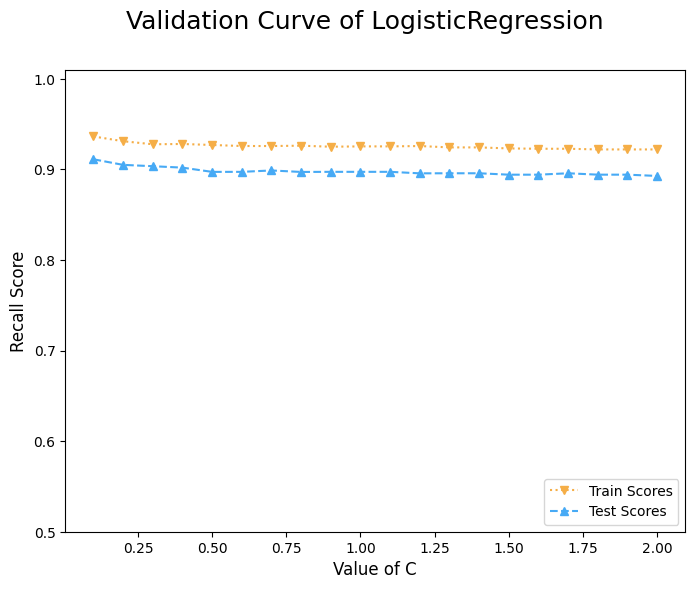

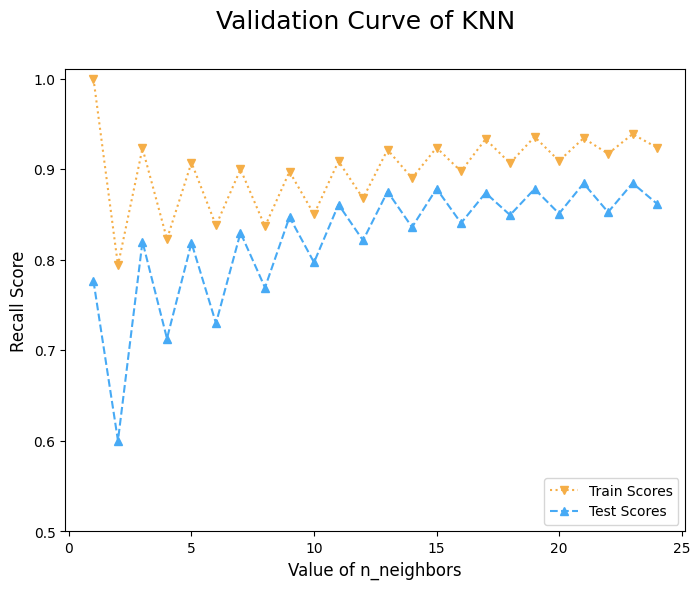

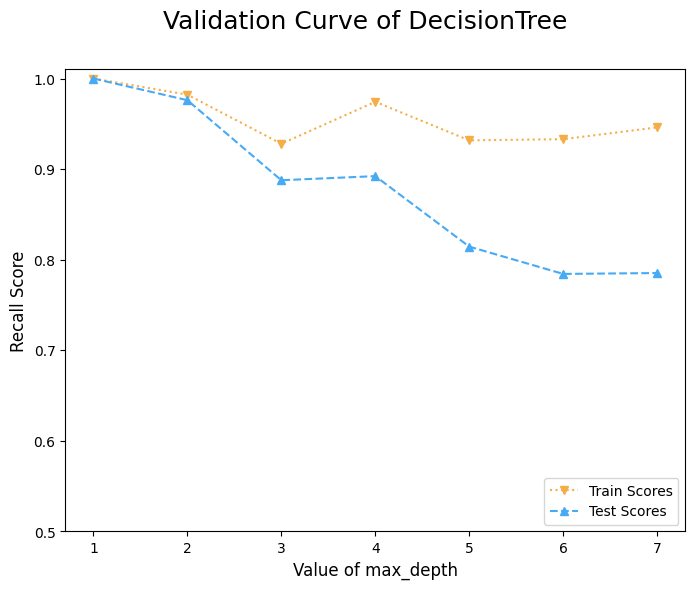

In [23]:
# Plotting validation curve of each model

for model in Models:
    PlotValidationCurve(model)

In [24]:
# Defining best hyper parameters

BestParameter_LogisticRegression = 0.1
BestParameter_KNN = 15
BestParameter_DecisionTree = 3

In [25]:
# Training models with the best hyper parameters

for model in Models:
    print(f'START RETRAINING :: {model}')
    global_vars[f'Model_{model}'].set_params(**{global_vars[f'Parameter_{model}']:global_vars[f'BestParameter_{model}']})
    global_vars[f'Model_{model}'].fit(train_X,train_y)
    print(f'END RETRAINING :: {model}\n')

START RETRAINING :: LogisticRegression
END RETRAINING :: LogisticRegression

START RETRAINING :: KNN
END RETRAINING :: KNN

START RETRAINING :: DecisionTree
END RETRAINING :: DecisionTree



In [26]:
# Saving best models 

for model in Models:
    with open(f'BestModel_{model}.pkl','wb') as model_file:
        pickle.dump(global_vars[f'Model_{model}'],model_file,protocol=5)

# 6. Model Evaluation

Using the test set to validate the models with the best parameters, Decision Tree Model is the one that achieved the best metric, but when evaluating more carefully the metric used and with the highlighted in [Exploratory Data Analysis](../ExploratoryDataAnalysis/ExploratoryDataAnalysis.ipynb) it is understood that the best rule is always to predict 'Yes' to every instance, therefore this model suffers from underfitting because it is not learning any pattern but a naive rule, so it has a bias problem.

In the case of KNN Model, it belongs to an overfit scenario because in the training set it does much better than in the test set, this is related to a variance problem because small changes in the neighbors make the final prediction change together with the fact that the instances are not linearly separable leaving that the minimum change makes the prediction change.

Dejando a Logistic Regression Model como el mejor modelo debido a que se comporta de igual manera tanto en el conjunto de prueba como de entrenamiento, haciendo que haya capturado y aprendido los patrones para hacer una clasificación eficiente entre clases. 

In [27]:
# Evaluations over Test Set

EvaluateModels(Models,test_X,test_y,'Test')

Evaluations on Test Set

Evaluation of LogisticRegression ::
Recall :: 0.9382716049382716

Evaluation of KNN ::
Recall :: 0.8765432098765432

Evaluation of DecisionTree ::
Recall :: 0.9876543209876543



In [28]:
# Evaluations over Train Set

EvaluateModels(Models,train_X,train_y,'Train')

Evaluations on Train Set

Evaluation of LogisticRegression ::
Recall :: 0.9309309309309309

Evaluation of KNN ::
Recall :: 0.9279279279279279

Evaluation of DecisionTree ::
Recall :: 0.990990990990991

